In [11]:
!pip install -q ultralytics --upgrade



In [54]:
import os, random, pathlib, zipfile, shutil
import pandas as pd, numpy as np, torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
)
from ultralytics import YOLO
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

IMG_SIZE    = 224
BATCH_SIZE  = 32
NUM_WORKERS = 4
EPOCHS_BL   = 10
EPOCHS_IMP  = 20
device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [55]:
DATA_DIR = pathlib.Path("/kaggle/input/realwaste/realwaste-main/RealWaste")
all_images = []
for class_idx, class_name in enumerate(sorted(p.name for p in DATA_DIR.iterdir())):
    for img_path in (DATA_DIR / class_name).glob("*"):
        all_images.append((str(img_path), class_idx, class_name))
df = pd.DataFrame(all_images, columns=["path","label","class"])
print(df['class'].value_counts())
NUM_CLASSES = df.label.nunique()
class_names = sorted(df["class"].unique())
print(f"Found {NUM_CLASSES} classes: {class_names}")


class
Plastic                921
Metal                  790
Paper                  500
Miscellaneous Trash    495
Cardboard              461
Vegetation             436
Glass                  420
Food Organics          411
Textile Trash          318
Name: count, dtype: int64
Found 9 classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


In [56]:
train_df, tmp_df = train_test_split(
    df, test_size=0.30, random_state=SEED, stratify=df["label"]
)
val_df, test_df = train_test_split(
    tmp_df, test_size=0.50, random_state=SEED, stratify=tmp_df["label"]
)
print(f"train: {len(train_df)}, val: {len(val_df)}, test: {len(test_df)}")


train: 3326, val: 713, test: 713


In [57]:
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
val_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE+32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

class WasteDataset(Dataset):
    def __init__(self, df, tfm):
        self.df  = df.reset_index(drop=True)
        self.tfm = tfm
    def __len__(self):
        return len(self.df)
    def __getitem__(self, i):
        img = Image.open(self.df.loc[i,"path"]).convert("RGB")
        x = self.tfm(img)
        y = self.df.loc[i,"label"]
        return x, y

train_dl = DataLoader(
    WasteDataset(train_df, train_tfms),
    batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)
val_dl = DataLoader(
    WasteDataset(val_df, val_tfms),
    batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)
test_dl = DataLoader(
    WasteDataset(test_df, val_tfms),
    batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True
)


In [15]:
metrics = {
    "acc"       : MulticlassAccuracy(NUM_CLASSES, average="micro").to(device),
    "f1_macro"  : MulticlassF1Score(NUM_CLASSES, average="macro").to(device),
    "f1_weight" : MulticlassF1Score(NUM_CLASSES, average="weighted").to(device),
    "top3"      : MulticlassAccuracy(NUM_CLASSES, top_k=3).to(device),
    "cm"        : MulticlassConfusionMatrix(NUM_CLASSES).to(device),
}

In [60]:
import shutil
from pathlib import Path

OUT_DIR = Path("realwaste_split")
if OUT_DIR.exists():
    shutil.rmtree(OUT_DIR)

for split, df_split in [("train", train_df), ("val", val_df), ("test", test_df)]:
    for _, row in df_split.iterrows():
        cls = row["class"]
        src = Path(row["path"])
        dst_dir = OUT_DIR / split / cls
        dst_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(src, dst_dir / src.name)

print("✓ Папки realwaste_split/train, val, test созданы")


✓ Папки realwaste_split/train, val, test созданы


In [66]:
from pathlib import Path

ROOT = Path("realwaste_split").resolve()

yaml_content = f"""
train: {ROOT}/train
val:   {ROOT}/val
test:  {ROOT}/test

nc: {NUM_CLASSES}
names: {class_names}
"""
with open("realwaste.yaml", "w") as f:
    f.write(yaml_content.strip())
print(open("realwaste.yaml").read())


train: /kaggle/working/realwaste_split/train
val:   /kaggle/working/realwaste_split/val
test:  /kaggle/working/realwaste_split/test

nc: 9
names: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


In [69]:
import shutil, os

src = "realwaste_split"
dst = "/kaggle/working/datasets/realwaste_split"

if os.path.exists(dst):
    shutil.rmtree(dst)

shutil.copytree(src, dst)
print(f"✓ Скопировали `{src}` → `{dst}`")


✓ Скопировали `realwaste_split` → `/kaggle/working/datasets/realwaste_split`


In [73]:
yaml = f"""
path: realwaste_split

train: train
val:   val
test:  test

nc: {NUM_CLASSES}
names: {class_names}
""".strip()

with open("realwaste.yaml","w") as f:
    f.write(yaml)

print(open("realwaste.yaml").read())


# корень ваших данных — realwaste_split (ищется в datasets_dir)
path: realwaste_split

train: train
val:   val
test:  test

nc: 9
names: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


In [76]:
ROOT = str(Path("realwaste_split").resolve())
model_clf = YOLO('yolov8n-cls.pt', task='classify')
model_clf.train(
    data=ROOT,       
    epochs=EPOCHS_BL,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    workers=NUM_WORKERS,
    device=device.type,
    name='baseline_yolov8n-cls'
)



Ultralytics 8.3.130 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/realwaste_split, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline_yolov8n-cls3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, p

train: Scanning /kaggle/working/realwaste_split/train... 3326 images, 0 corrupt: 100%|██████████| 3326/3326 [00:01<00:00, 3025.56it/s]


train: New cache created: /kaggle/working/realwaste_split/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 559.5±456.8 MB/s, size: 155.2 KB)


val: Scanning /kaggle/working/realwaste_split/val... 713 images, 0 corrupt: 100%|██████████| 713/713 [00:00<00:00, 2936.03it/s]

val: New cache created: /kaggle/working/realwaste_split/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/baseline_yolov8n-cls3
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:01<00:00,  6.10it/s]

                   all      0.648       0.99



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.83it/s]

                   all       0.79      0.996

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.81it/s]

                   all      0.827      0.996

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.29it/s]

                   all      0.826      0.996

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:01<00:00,  6.04it/s]

                   all      0.864      0.999

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.80it/s]

                   all      0.857          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.88it/s]

                   all      0.877      0.999

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.98it/s]

                   all      0.882          1

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.84it/s]

                   all      0.889          1

      Epoch    GPU_mem       loss  Instances       Size



      10/10      2.64G     0.2377         30        224: 100%|██████████| 104/104 [00:15<00:00,  6.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.97it/s]

                   all      0.896          1

10 epochs completed in 0.050 hours.
Optimizer stripped from runs/classify/baseline_yolov8n-cls3/weights/last.pt, 3.0MB


Optimizer stripped from runs/classify/baseline_yolov8n-cls3/weights/best.pt, 3.0MB

Validating runs/classify/baseline_yolov8n-cls3/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,446,409 parameters, 0 gradients, 3.3 GFLOPs
train: /kaggle/working/realwaste_split/train... found 3326 images in 9 classes ✅ 
val: /kaggle/working/realwaste_split/val... found 713 images in 9 classes ✅ 
test: /kaggle/working/realwaste_split/test... found 713 images in 9 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      0.896          1
Speed: 0.1ms preprocess, 0.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/baseline_yolov8n-cls3


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b7de5660810>
curves: []
curves_results: []
fitness: 0.948106586933136
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.896213173866272, 'metrics/accuracy_top5': 1.0, 'fitness': 0.948106586933136}
save_dir: PosixPath('runs/classify/baseline_yolov8n-cls3')
speed: {'preprocess': 0.06615461851043615, 'inference': 0.2234480659135596, 'loss': 0.0002156535746537209, 'postprocess': 0.00033953015120333614}
task: 'classify'
top1: 0.896213173866272
top5: 1.0

Inferencing on test:   0%|          | 0/23 [00:00<?, ?it/s]

Accuracy (micro)     : 0.3745
F1-score (macro)     : 0.3208
F1-score (weighted)  : 0.3594


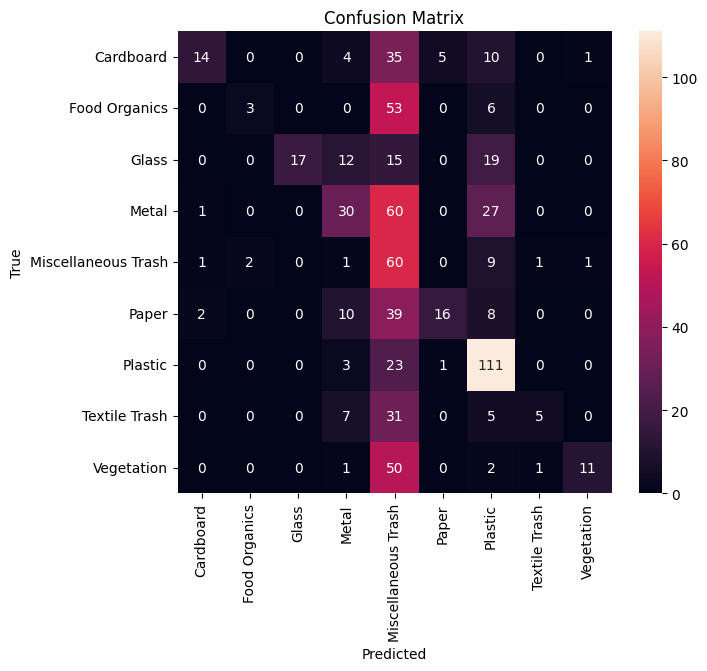

In [79]:
import torch
from tqdm.auto import tqdm
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
)

# 1) Определяем ваши метрики
metrics = {
    "acc"       : MulticlassAccuracy(NUM_CLASSES, average="micro").to(device),
    "f1_macro"  : MulticlassF1Score(NUM_CLASSES, average="macro").to(device),
    "f1_weight" : MulticlassF1Score(NUM_CLASSES, average="weighted").to(device),
    "top3"      : MulticlassAccuracy(NUM_CLASSES, top_k=3).to(device),
    "cm"        : MulticlassConfusionMatrix(NUM_CLASSES).to(device),
}

model = model_clf.model
model.to(device).eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in tqdm(test_dl, desc="Inferencing on test"):
        xb = xb.to(device); yb = yb.to(device)
        out = model(xb)
        logits = out[1] if isinstance(out, (tuple, list)) else out
        preds = logits.argmax(dim=1)
        all_preds.append(preds)
        all_labels.append(yb)

y_pred = torch.cat(all_preds)
y_true = torch.cat(all_labels)

acc       = metrics["acc"](y_pred, y_true)
f1_macro  = metrics["f1_macro"](y_pred, y_true)
f1_weight = metrics["f1_weight"](y_pred, y_true)
cm        = metrics["cm"](y_pred, y_true)

print(f"Accuracy (micro)     : {acc:.4f}")
print(f"F1-score (macro)     : {f1_macro:.4f}")
print(f"F1-score (weighted)  : {f1_weight:.4f}")

import matplotlib.pyplot as plt, seaborn as sns

plt.figure(figsize=(7,6))
sns.heatmap(cm.cpu().numpy(), annot=True, fmt="d",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Чето вообще все фигово выглядит

In [80]:
from torch.utils.data import WeightedRandomSampler

counts = train_df['label'].value_counts().sort_index()
print("Train class counts:\n", counts)

class_weights = 1.0 / counts.values
sample_weights = train_df['label'].map(lambda x: class_weights[x]).values
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_dl = DataLoader(
    WasteDataset(train_df, train_tfms),
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True
)


Train class counts:
 label
0    323
1    288
2    294
3    553
4    346
5    350
6    645
7    222
8    305
Name: count, dtype: int64


In [85]:
NUM_CLASSES = df.label.nunique()
class_names = sorted(df['class'].unique())
ROOT = str(Path("realwaste_split").resolve())



In [86]:
counts = train_df['label'].value_counts().sort_index()
class_weights = 1.0 / counts.values
sample_weights = train_df['label'].map(lambda x: class_weights[x]).values

sampler = WeightedRandomSampler(sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)


In [87]:
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, 
                           saturation=0.2, hue=0.1),
    transforms.RandomErasing(p=0.4, scale=(0.02,0.2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE+32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225]),
])


In [88]:
class WasteDataset(Dataset):
    def __init__(self, df, tfm):
        self.df  = df.reset_index(drop=True)
        self.tfm = tfm
    def __len__(self):
        return len(self.df)
    def __getitem__(self, i):
        img = Image.open(self.df.loc[i,'path']).convert('RGB')
        return self.tfm(img), self.df.loc[i,'label']

train_ds = WasteDataset(train_df, train_tfms)
val_ds   = WasteDataset(val_df,   val_tfms)
test_ds  = WasteDataset(test_df,  val_tfms)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE,
                      sampler=sampler,
                      num_workers=NUM_WORKERS,
                      pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                      shuffle=False,
                      num_workers=NUM_WORKERS,
                      pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE,
                      shuffle=False,
                      num_workers=NUM_WORKERS,
                      pin_memory=True)


In [89]:
model_imp = YOLO('yolov8m-cls.pt', task='classify')
model_imp.train(
    data=ROOT,
    epochs=EPOCHS_IMP,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    workers=NUM_WORKERS,
    device=device.type,
    name='improved_yolov8m-cls',
    lr0=0.01,
    lrf=0.1
)


Ultralytics 8.3.130 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/realwaste_split, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=improved_yolov8m-cls, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pos

train: Scanning /kaggle/working/realwaste_split/train... 3326 images, 0 corrupt: 100%|██████████| 3326/3326 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 761.4±678.2 MB/s, size: 155.2 KB)


val: Scanning /kaggle/working/realwaste_split/val... 713 images, 0 corrupt: 100%|██████████| 713/713 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 38 weight(decay=0.0), 39 weight(decay=0.0005), 39 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/improved_yolov8m-cls
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.63it/s]

                   all      0.746      0.989



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.54it/s]

                   all      0.846          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.80it/s]

                   all      0.805      0.997



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.72it/s]

                   all      0.856      0.994



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.86it/s]

                   all      0.878      0.997



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.74it/s]

                   all      0.884      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.51it/s]

                   all      0.896      0.997



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.81it/s]

                   all      0.886      0.996



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.78it/s]

                   all      0.903      0.996



      Epoch    GPU_mem       loss  Instances       Size


      10/20      1.62G    0.09691         30        224: 100%|██████████| 104/104 [00:16<00:00,  6.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.81it/s]

                   all      0.907      0.997



      Epoch    GPU_mem       loss  Instances       Size


      11/20      1.62G     0.1056         30        224: 100%|██████████| 104/104 [00:16<00:00,  6.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:01<00:00,  6.04it/s]

                   all      0.906      0.996



      Epoch    GPU_mem       loss  Instances       Size


      12/20      1.62G     0.1003         30        224: 100%|██████████| 104/104 [00:16<00:00,  6.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.63it/s]

                   all       0.92      0.997



      Epoch    GPU_mem       loss  Instances       Size


      13/20      1.62G     0.0776         30        224: 100%|██████████| 104/104 [00:15<00:00,  6.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.59it/s]

                   all      0.913      0.999



      Epoch    GPU_mem       loss  Instances       Size


      14/20      1.62G    0.06124         30        224: 100%|██████████| 104/104 [00:16<00:00,  6.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.63it/s]

                   all      0.921      0.999



      Epoch    GPU_mem       loss  Instances       Size


      15/20      1.62G    0.05914         30        224: 100%|██████████| 104/104 [00:16<00:00,  6.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]

                   all      0.924      0.996



      Epoch    GPU_mem       loss  Instances       Size


      16/20      1.62G    0.05141         30        224: 100%|██████████| 104/104 [00:15<00:00,  6.63it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.84it/s]

                   all      0.926      0.999



      Epoch    GPU_mem       loss  Instances       Size


      17/20      1.62G    0.05222         30        224: 100%|██████████| 104/104 [00:16<00:00,  6.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:01<00:00,  6.04it/s]

                   all      0.924      0.999



      Epoch    GPU_mem       loss  Instances       Size


      18/20      1.62G    0.03922         30        224: 100%|██████████| 104/104 [00:15<00:00,  6.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:01<00:00,  6.04it/s]

                   all      0.923      0.999



      Epoch    GPU_mem       loss  Instances       Size


      19/20      1.62G    0.04496         30        224: 100%|██████████| 104/104 [00:16<00:00,  6.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.87it/s]

                   all       0.93      0.999



      Epoch    GPU_mem       loss  Instances       Size


      20/20      1.62G    0.03214         30        224: 100%|██████████| 104/104 [00:15<00:00,  6.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  4.90it/s]

                   all      0.933      0.999



20 epochs completed in 0.106 hours.
Optimizer stripped from runs/classify/improved_yolov8m-cls/weights/last.pt, 31.7MB
Optimizer stripped from runs/classify/improved_yolov8m-cls/weights/best.pt, 31.7MB

Validating runs/classify/improved_yolov8m-cls/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8m-cls summary (fused): 42 layers, 15,774,185 parameters, 0 gradients, 41.6 GFLOPs
train: /kaggle/working/realwaste_split/train... found 3326 images in 9 classes ✅ 
val: /kaggle/working/realwaste_split/val... found 713 images in 9 classes ✅ 
test: /kaggle/working/realwaste_split/test... found 713 images in 9 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:01<00:00,  6.02it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      0.934      0.999
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/improved_yolov8m-cls


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b7de5363450>
curves: []
curves_results: []
fitness: 0.9663394391536713
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9340813755989075, 'metrics/accuracy_top5': 0.9985975027084351, 'fitness': 0.9663394391536713}
save_dir: PosixPath('runs/classify/improved_yolov8m-cls')
speed: {'preprocess': 0.07118607152741256, 'inference': 0.7027562875152473, 'loss': 0.0002141514746341619, 'postprocess': 0.000487870966791447}
task: 'classify'
top1: 0.9340813755989075
top5: 0.9985975027084351

Inferencing:   0%|          | 0/23 [00:00<?, ?it/s]

acc=0.5610, f1_macro=0.5512, f1_weight=0.5609


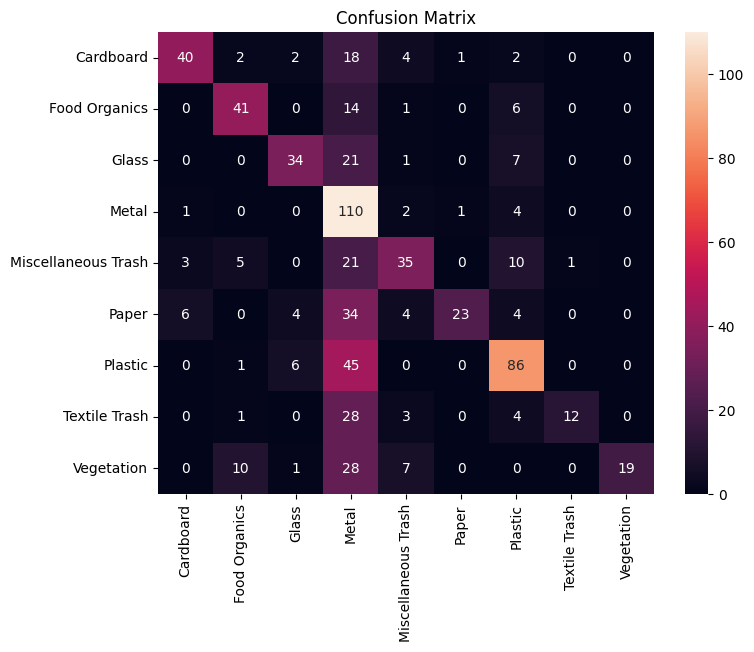

In [96]:
import torch
from tqdm.auto import tqdm
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
)
import matplotlib.pyplot as plt, seaborn as sns

# инициализируем
k = min(3, NUM_CLASSES)
metrics = {
    "acc"       : MulticlassAccuracy(NUM_CLASSES, average="micro").to(device),
    "f1_macro"  : MulticlassF1Score(NUM_CLASSES, average="macro").to(device),
    "f1_weight" : MulticlassF1Score(NUM_CLASSES, average="weighted").to(device),
    "cm"        : MulticlassConfusionMatrix(NUM_CLASSES).to(device),
}

# инференс на model_imp
mdl = model_imp.model.to(device).eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for xb, yb in tqdm(test_dl, desc="Inferencing"):
        xb, yb = xb.to(device), yb.to(device)
        out = mdl(xb)
        logits = out[1] if isinstance(out,(tuple,list)) else out
        preds = logits.argmax(dim=1)
        all_preds.append(preds); all_labels.append(yb)

y_pred = torch.cat(all_preds)
y_true = torch.cat(all_labels)

# считаем
acc       = metrics["acc"](y_pred, y_true)
f1m       = metrics["f1_macro"](y_pred, y_true)
f1w       = metrics["f1_weight"](y_pred, y_true)
cm        = metrics["cm"](y_pred, y_true)

print(f"acc={acc:.4f}, f1_macro={f1m:.4f}, f1_weight={f1w:.4f}")

# confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm.cpu().numpy(), annot=True, fmt="d",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix"); plt.show()


Стало лучше, но все равно плохо. Из матриц видно что метал плохо определяется и со всем путается.

Перейдем к трансформерам.

In [97]:
counts = train_df['label'].value_counts().sort_index()
class_weights   = 1.0 / counts.values
sample_weights  = train_df['label'].map(lambda x: class_weights[x]).values
sampler         = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
val_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE+32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

class WasteDataset(Dataset):
    def __init__(self, df, tfm):
        self.df  = df.reset_index(drop=True); self.tfm = tfm
    def __len__(self):    return len(self.df)
    def __getitem__(self, i):
        img = Image.open(self.df.loc[i,'path']).convert('RGB')
        return self.tfm(img), self.df.loc[i,'label']

train_dl = DataLoader(WasteDataset(train_df, train_tfms),
                      batch_size=BATCH_SIZE, sampler=sampler,
                      num_workers=NUM_WORKERS, pin_memory=True)
val_dl   = DataLoader(WasteDataset(val_df,   val_tfms),
                      batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=True)
test_dl  = DataLoader(WasteDataset(test_df,  val_tfms),
                      batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=True)


In [98]:
model_bl = YOLO('yolo11n-cls.pt', task='classify')
model_bl.train(
    data=ROOT,         
    epochs=EPOCHS_BL,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    workers=NUM_WORKERS,
    device=device.type,
    name='baseline_yolo11n-cls',
    lr0=0.01,          
    lrf=0.1            
)


100%|██████████| 5.52M/5.52M [00:00<00:00, 73.4MB/s]

Ultralytics 8.3.130 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/realwaste_split, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline_yolo11n-cls, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pos

train: /kaggle/working/realwaste_split/train... found 3326 images in 9 classes ✅ 
val: /kaggle/working/realwaste_split/val... found 713 images in 9 classes ✅ 
test: /kaggle/working/realwaste_split/test... found 713 images in 9 classes ✅ 
Overriding model.yaml nc=80 with nc=9

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  u

train: Scanning /kaggle/working/realwaste_split/train... 3326 images, 0 corrupt: 100%|██████████| 3326/3326 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 689.5±526.4 MB/s, size: 155.2 KB)


val: Scanning /kaggle/working/realwaste_split/val... 713 images, 0 corrupt: 100%|██████████| 713/713 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/baseline_yolo11n-cls
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.93it/s]

                   all      0.762      0.992



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:01<00:00,  6.17it/s]

                   all      0.813          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:01<00:00,  6.18it/s]

                   all      0.816      0.996



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.62it/s]

                   all      0.833      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.80it/s]

                   all       0.86          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:01<00:00,  6.08it/s]

                   all       0.87          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:01<00:00,  6.09it/s]

                   all      0.896      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.99it/s]

                   all      0.896      0.997



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.93it/s]

                   all      0.907      0.997



      Epoch    GPU_mem       loss  Instances       Size


      10/10     0.863G      0.181         30        224: 100%|██████████| 104/104 [00:16<00:00,  6.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:01<00:00,  6.29it/s]

                   all      0.905      0.999



10 epochs completed in 0.051 hours.
Optimizer stripped from runs/classify/baseline_yolo11n-cls/weights/last.pt, 3.2MB
Optimizer stripped from runs/classify/baseline_yolo11n-cls/weights/best.pt, 3.2MB

Validating runs/classify/baseline_yolo11n-cls/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 47 layers, 1,537,553 parameters, 0 gradients, 3.2 GFLOPs
train: /kaggle/working/realwaste_split/train... found 3326 images in 9 classes ✅ 
val: /kaggle/working/realwaste_split/val... found 713 images in 9 classes ✅ 
test: /kaggle/working/realwaste_split/test... found 713 images in 9 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.45it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      0.907      0.997
Speed: 0.1ms preprocess, 0.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/baseline_yolo11n-cls


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b7eb4249350>
curves: []
curves_results: []
fitness: 0.952314168214798
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9074333906173706, 'metrics/accuracy_top5': 0.9971949458122253, 'fitness': 0.952314168214798}
save_dir: PosixPath('runs/classify/baseline_yolo11n-cls')
speed: {'preprocess': 0.07345088359274556, 'inference': 0.23884099298462122, 'loss': 0.0002172945378040294, 'postprocess': 0.00033080225226617593}
task: 'classify'
top1: 0.9074333906173706
top5: 0.9971949458122253

In [99]:
# более крупная трансформерная версия (YOLO11m-cls)
model_imp = YOLO('yolo11m-cls.pt', task='classify')
model_imp.train(
    data=ROOT,
    epochs=EPOCHS_IMP,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    workers=NUM_WORKERS,
    device=device.type,
    name='improved_yolo11m-cls',
    lr0=0.01,
    lrf=0.1
)


100%|██████████| 22.4M/22.4M [00:00<00:00, 176MB/s]


Ultralytics 8.3.130 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/realwaste_split, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=improved_yolo11m-cls, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pos

train: Scanning /kaggle/working/realwaste_split/train... 3326 images, 0 corrupt: 100%|██████████| 3326/3326 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 726.8±717.2 MB/s, size: 155.2 KB)


val: Scanning /kaggle/working/realwaste_split/val... 713 images, 0 corrupt: 100%|██████████| 713/713 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 49 weight(decay=0.0), 50 weight(decay=0.0005), 50 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/improved_yolo11m-cls
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.81it/s]

                   all      0.822      0.994



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:01<00:00,  6.02it/s]

                   all       0.83      0.993



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.91it/s]

                   all      0.788      0.994



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.37it/s]

                   all      0.809      0.992



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.73it/s]

                   all      0.823      0.994



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.81it/s]

                   all      0.868      0.996



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.62it/s]

                   all      0.865      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  6.00it/s]

                   all      0.875          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:01<00:00,  6.01it/s]

                   all      0.875          1



      Epoch    GPU_mem       loss  Instances       Size


      10/20      2.18G     0.2205         30        224: 100%|██████████| 104/104 [00:16<00:00,  6.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.89it/s]

                   all      0.878      0.999



      Epoch    GPU_mem       loss  Instances       Size


      11/20      2.18G     0.2295         30        224: 100%|██████████| 104/104 [00:17<00:00,  6.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.97it/s]

                   all      0.896      0.994



      Epoch    GPU_mem       loss  Instances       Size


      12/20      2.18G     0.2296         30        224: 100%|██████████| 104/104 [00:15<00:00,  6.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.76it/s]

                   all      0.885      0.999



      Epoch    GPU_mem       loss  Instances       Size


      13/20      2.18G     0.1939         30        224: 100%|██████████| 104/104 [00:16<00:00,  6.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:01<00:00,  6.20it/s]

                   all      0.891      0.999



      Epoch    GPU_mem       loss  Instances       Size


      14/20      2.18G     0.1529         30        224: 100%|██████████| 104/104 [00:16<00:00,  6.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.86it/s]

                   all      0.886      0.999



      Epoch    GPU_mem       loss  Instances       Size


      15/20      2.18G     0.1372         30        224: 100%|██████████| 104/104 [00:16<00:00,  6.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.91it/s]

                   all      0.903      0.999



      Epoch    GPU_mem       loss  Instances       Size


      16/20      2.18G     0.1115         30        224: 100%|██████████| 104/104 [00:16<00:00,  6.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.76it/s]

                   all      0.899      0.994



      Epoch    GPU_mem       loss  Instances       Size


      17/20      2.18G    0.08714         30        224: 100%|██████████| 104/104 [00:16<00:00,  6.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.93it/s]

                   all      0.917      0.997



      Epoch    GPU_mem       loss  Instances       Size


      18/20      2.18G    0.08839         30        224: 100%|██████████| 104/104 [00:16<00:00,  6.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:01<00:00,  6.04it/s]

                   all      0.919      0.997



      Epoch    GPU_mem       loss  Instances       Size


      19/20      2.18G    0.07762         30        224: 100%|██████████| 104/104 [00:16<00:00,  6.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.61it/s]

                   all      0.919      0.999



      Epoch    GPU_mem       loss  Instances       Size


      20/20      2.18G    0.07218         30        224: 100%|██████████| 104/104 [00:16<00:00,  6.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.59it/s]

                   all      0.917      0.997



20 epochs completed in 0.106 hours.
Optimizer stripped from runs/classify/improved_yolo11m-cls/weights/last.pt, 20.9MB
Optimizer stripped from runs/classify/improved_yolo11m-cls/weights/best.pt, 20.9MB

Validating runs/classify/improved_yolo11m-cls/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m-cls summary (fused): 57 layers, 10,353,161 parameters, 0 gradients, 39.3 GFLOPs
train: /kaggle/working/realwaste_split/train... found 3326 images in 9 classes ✅ 
val: /kaggle/working/realwaste_split/val... found 713 images in 9 classes ✅ 
test: /kaggle/working/realwaste_split/test... found 713 images in 9 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:02<00:00,  5.85it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      0.919      0.999
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/improved_yolo11m-cls


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b7eea305d50>
curves: []
curves_results: []
fitness: 0.9586255252361298
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9186535477638245, 'metrics/accuracy_top5': 0.9985975027084351, 'fitness': 0.9586255252361298}
save_dir: PosixPath('runs/classify/improved_yolo11m-cls')
speed: {'preprocess': 0.07123184992913334, 'inference': 0.7085205329575809, 'loss': 0.00025602524849810854, 'postprocess': 0.0004479018253524726}
task: 'classify'
top1: 0.9186535477638245
top5: 0.9985975027084351

Inferencing:   0%|          | 0/23 [00:00<?, ?it/s]

Inferencing:   0%|          | 0/23 [00:00<?, ?it/s]

Baseline YOLO11n-cls: {'acc': 0.3843, 'f1_macro': 0.3325, 'f1_weight': 0.3507}
Improved YOLO11m-cls: {'acc': 0.568, 'f1_macro': 0.5381, 'f1_weight': 0.5534}


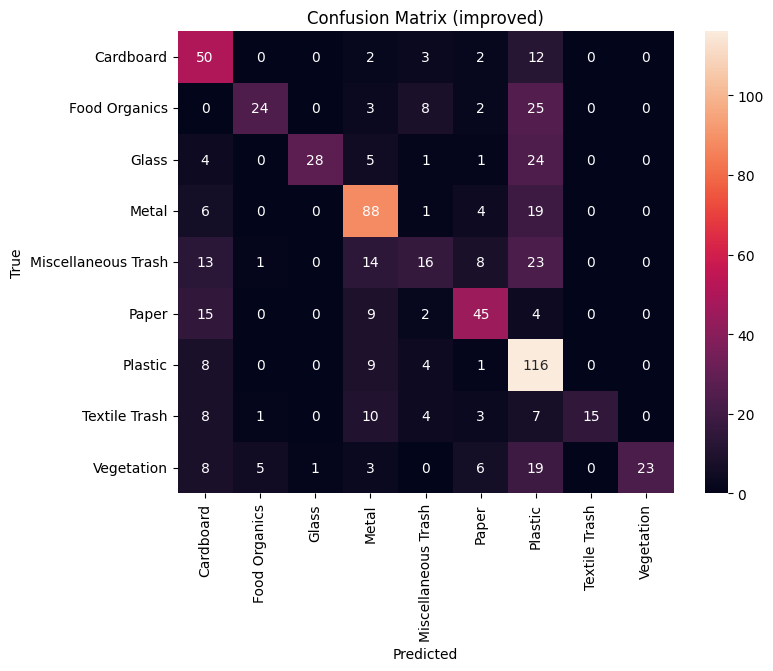

In [100]:
# инициализация torchmetrics
k = min(3, NUM_CLASSES)
metrics = {
    "acc"      : MulticlassAccuracy(NUM_CLASSES, average="micro").to(device),
    "f1_macro" : MulticlassF1Score(NUM_CLASSES, average="macro").to(device),
    "f1_weight": MulticlassF1Score(NUM_CLASSES, average="weighted").to(device),
    "cm"       : MulticlassConfusionMatrix(NUM_CLASSES).to(device),
}

def eval_model(yolo_model, dl):
    mdl = yolo_model.model.to(device).eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in tqdm(dl, desc="Inferencing"):
            xb, yb = xb.to(device), yb.to(device)
            out = mdl(xb)
            logits = out[1] if isinstance(out,(tuple,list)) else out
            preds = logits.argmax(dim=1)
            all_preds.append(preds); all_labels.append(yb)
    y_pred = torch.cat(all_preds); y_true = torch.cat(all_labels)
    return {
        'acc':      metrics["acc"](y_pred, y_true).item(),
        'f1_macro': metrics["f1_macro"](y_pred, y_true).item(),
        'f1_weight':metrics["f1_weight"](y_pred, y_true).item(),
        'cm':       metrics["cm"](y_pred, y_true).cpu().numpy()
    }

# eval baseline
res_bl = eval_model(model_bl, test_dl)
# eval improved
res_imp = eval_model(model_imp, test_dl)

# печать
print("Baseline YOLO11n-cls:", {k:round(v,4) for k,v in res_bl.items() if k!='cm'})
print("Improved YOLO11m-cls:",{k:round(v,4) for k,v in res_imp.items() if k!='cm'})

# confusion matrix improved
plt.figure(figsize=(8,6))
sns.heatmap(res_imp['cm'], annot=True, fmt="d",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix (improved)")
plt.show()
